# Water Main Break EDA

This notebook is a quick analysis of the water main break data with the end result being a Plotly scatter mapbox of all the breaks, with their colour being the year that they broke, and their size being the number of breaks they've experienced.

In previous notebooks, I cleaned up the data to get it ready for the ML models, but for this notebook I've imported the original dataset so that we have the necessary data to create the visuals we're looking for.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
break_data = pd.read_csv('../data/Nov_10_22_Water_Main_Breaks.csv')
break_data.sample(5)

,X,Y,OBJECTID,WATBREAKINCIDENTID,INCIDENT_DATE,BREAK_TYPE,ROAD_CLOSED,SIDEWALK_CLOSED,HOUR_IMPACTED,UNITS_IMPACTED,...,CIVIC_NUMBER,STREET,ASSETID,ASSET_DEPTH,FROST_DEPTH,ASSET_SIZE,ASSET_YEAR_INSTALLED,ASSET_MATERIAL,ASSET_EXISTS,GLOBALID
809,-80.450398,43.426531,8794,542,2001/12/11 00:00:00+00,MAIN,Open,Open,8-12 hours,NaN,...,230,NINTH AVE,27830,NaN,NaN,200.0,1961.0,CI,Y,7cede1a0-fef1-404b-8045-b48531629f88
41,-80.460743,43.434090,8026,305,2005/03/13 00:00:00+00,MAIN,Open,Open,8-12 hours,NaN,...,119,PLYMOUTH RD,76727,NaN,NaN,150.0,2010.0,PVC,N,ef4fe908-6aa2-44cd-8f4b-4cfc9c0a05f3
280,-80.511417,43.421677,8265,1789,2013/12/16 00:00:00+00,MAIN,Open,Open,8-12 hours,NaN,...,87,RUSKVIEW RD,87984,NaN,NaN,150.0,1963.0,CI,Y,8a3ad6d5-69fb-410c-90b1-bc272e1a087f
428,-80.460725,43.435586,8413,342,2001/07/29 00:00:00+00,MAIN,Open,Open,8-12 hours,NaN,...,58,PLYMOUTH RD,86556,NaN,NaN,150.0,2010.0,PVC,N,737133d1-a907-4ef6-bcc5-003c13559701
296,-80.508147,43.430088,8281,977,2006/06/22 00:00:00+00,MAIN,Open,Open,8-12 hours,NaN,...,140,WESTMOUNT RD E,42530,NaN,NaN,150.0,1959.0,CI,Y,36c8b464-c5fd-47ad-a9be-b33588554e37


## Data Cleaning

Here I'll take out well over half of the original features so we have something nicer to look at when dispalying the dataframe for inspection, but first we'll convert our X and Y variables to latitude and longitude and then convert all of the columns to lowercase.

In [3]:
break_data.rename(columns={'X': 'lon', 'Y': 'lat'}, inplace=True)

In [4]:
# convert column names to lower case
break_data.columns = map(str.lower, break_data.columns)  # convert column names to lower case
break_data.columns

Index(['lon', 'lat', 'objectid', 'watbreakincidentid', 'incident_date',
       'break_type', 'road_closed', 'sidewalk_closed', 'hour_impacted',
       'units_impacted', 'cw_service_request', 'status', 'status_date',
       'workorder', 'return_to_normal', 'break_nature', 'break_apparent_cause',
       'repair_type', 'new_section_length', 'maintenance_desc',
       'valves_closed', 'valves_opened', 'hydrants_called_out',
       'hydrants_called_back_in', 'positive_pressure_maintaned',
       'air_gap_maintaned', 'disinfected', 'mechanical_removal',
       'flushing_excavation', 'higher_velocity_flushing', 'anode_installed',
       'break_categorization', 'bacteria_testing_date',
       'health_dept_notification', 'moecc_sac_notification',
       'sac_reference_no', 'local_moe_office', 'bwa_dwa', 'bwa_dwa_declared',
       'proceedures_followed', 'record_change_reqd', 'roadsegmentid',
       'civic_number', 'street', 'assetid', 'asset_depth', 'frost_depth',
       'asset_size', 'asset_ye

In [5]:
break_data = break_data[['lon', 'lat', 'objectid', 'incident_date', 'break_type', 'hour_impacted', 'units_impacted', 'status',
                         'status_date', 'break_nature', 'break_apparent_cause', 'break_categorization', 'roadsegmentid', 
                         'street', 'assetid', 'asset_size', 'asset_year_installed', 'asset_material']]

In [6]:
break_data.head()

,lon,lat,objectid,incident_date,break_type,hour_impacted,units_impacted,status,status_date,break_nature,break_apparent_cause,break_categorization,roadsegmentid,street,assetid,asset_size,asset_year_installed,asset_material
0,-80.484005,43.462939,1,2017/12/01 15:15:00+00,MAIN,12-16 hours,47,REPAIR COMPLETED,2017/12/02 00:00:00+00,CORROSION AND FITTING/JOINT,AGE,CATEGORY 2,6961,LANCASTER ST W,134292,450.0,1937.0,CI
1,-80.515075,43.422742,7874,2001/03/26 00:00:00+00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6116,CLOVERDALE CRES,4101323,13.0,1965.0,XXX
2,-80.439811,43.445067,7875,2006/09/06 00:00:00+00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,13207,WREN CRES,4099987,25.0,1967.0,XXX
3,-80.510859,43.426478,7876,2006/09/11 00:00:00+00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6498,GREENBROOK DR,4642530,25.0,1964.0,PVC
4,-80.457520,43.443201,7877,2000/01/27 00:00:00+00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,22846,MONTGOMERY RD,4100648,25.0,1967.0,XXX


In [7]:
break_data.columns

Index(['lon', 'lat', 'objectid', 'incident_date', 'break_type',
       'hour_impacted', 'units_impacted', 'status', 'status_date',
       'break_nature', 'break_apparent_cause', 'break_categorization',
       'roadsegmentid', 'street', 'assetid', 'asset_size',
       'asset_year_installed', 'asset_material'],
      dtype='object')

There, much better!

Now that we have a prettier looking dataset, let's convert the date column to the proper format using pandas `to_datetime()` method.

In [8]:
break_data['incident_date'] = pd.to_datetime(break_data['incident_date'])  # convert incident date to date

In [10]:
print(break_data['incident_date'].info())
break_data.head()

<class 'pandas.core.series.Series'>
RangeIndex: 2750 entries, 0 to 2749
Series name: incident_date
Non-Null Count  Dtype              
--------------  -----              
2750 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 21.6 KB
None


,lon,lat,objectid,incident_date,break_type,hour_impacted,units_impacted,status,status_date,break_nature,break_apparent_cause,break_categorization,roadsegmentid,street,assetid,asset_size,asset_year_installed,asset_material
0,-80.484005,43.462939,1,2017-12-01 15:15:00+00:00,MAIN,12-16 hours,47,REPAIR COMPLETED,2017/12/02 00:00:00+00,CORROSION AND FITTING/JOINT,AGE,CATEGORY 2,6961,LANCASTER ST W,134292,450.0,1937.0,CI
1,-80.515075,43.422742,7874,2001-03-26 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6116,CLOVERDALE CRES,4101323,13.0,1965.0,XXX
2,-80.439811,43.445067,7875,2006-09-06 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,13207,WREN CRES,4099987,25.0,1967.0,XXX
3,-80.510859,43.426478,7876,2006-09-11 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6498,GREENBROOK DR,4642530,25.0,1964.0,PVC
4,-80.457520,43.443201,7877,2000-01-27 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,22846,MONTGOMERY RD,4100648,25.0,1967.0,XXX


I feel like I can take out the year and week and make them their own separate columns. This sort of future proofs the date data if we come back to it and analyze breaks by time of year or something like that.

In [11]:
break_data['week'] = break_data['incident_date'].dt.week  # add week column
break_data['year'] = break_data['incident_date'].dt.year  # add year column
break_data.head()

/var/folders/xs/d1td623j4l5_3s9p262jr4yw0000gn/T/ipykernel_3895/1305900504.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  break_data['week'] = break_data['incident_date'].dt.week  # add week column


,lon,lat,objectid,incident_date,break_type,hour_impacted,units_impacted,status,status_date,break_nature,break_apparent_cause,break_categorization,roadsegmentid,street,assetid,asset_size,asset_year_installed,asset_material,week,year
0,-80.484005,43.462939,1,2017-12-01 15:15:00+00:00,MAIN,12-16 hours,47,REPAIR COMPLETED,2017/12/02 00:00:00+00,CORROSION AND FITTING/JOINT,AGE,CATEGORY 2,6961,LANCASTER ST W,134292,450.0,1937.0,CI,48,2017
1,-80.515075,43.422742,7874,2001-03-26 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6116,CLOVERDALE CRES,4101323,13.0,1965.0,XXX,13,2001
2,-80.439811,43.445067,7875,2006-09-06 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,13207,WREN CRES,4099987,25.0,1967.0,XXX,36,2006
3,-80.510859,43.426478,7876,2006-09-11 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,6498,GREENBROOK DR,4642530,25.0,1964.0,PVC,37,2006
4,-80.457520,43.443201,7877,2000-01-27 00:00:00+00:00,SERVICE,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:28+00,UNKNOWN,OTHER,CATEGORY 1,22846,MONTGOMERY RD,4100648,25.0,1967.0,XXX,4,2000


## Number of breaks per year

It would be nice if we could see on a graph the number of breaks that have occurred each year. In order to do that we first need to know the number of breaks that actually do occur each year. Therefore we need to create a `breaks` or `num_breaks` column and calculate the number of times each pipe has broken.

In [14]:
# create new column for number of breaks for each assetid
break_data['breaks'] = break_data.groupby('assetid')['assetid'].transform('count')  # add breaks column

In [15]:
break_data.sample(5)

,lon,lat,objectid,incident_date,break_type,hour_impacted,units_impacted,status,status_date,break_nature,...,roadsegmentid,street,assetid,asset_size,asset_year_installed,asset_material,week,year,week_year,breaks
645,-80.451421,43.450595,8630,2014-01-16 00:00:00+00:00,MAIN,8-12 hours,NaN,REPAIR COMPLETED,2014/08/08 00:00:00+00,UNKNOWN,...,22924,HICKSON DR,18660,150.0,1960.0,CI,3,2014,3-2014,2
878,-80.482607,43.472268,8863,2014-02-26 00:00:00+00:00,MAIN,8-12 hours,NaN,REPAIR COMPLETED,2014/08/08 00:00:00+00,UNKNOWN,...,6991,MAPLE AVE,25160,150.0,1949.0,CI,9,2014,9-2014,1
34,-80.473002,43.451070,8019,2003-02-25 00:00:00+00:00,MAIN,8-12 hours,NaN,REPAIR COMPLETED,2011/12/15 15:38:26+00,UNKNOWN,...,11490,MERNER AVE,98392,150.0,2014.0,PVCO,9,2003,9-2003,4
2624,-80.436944,43.415572,40961,2021-06-25 11:20:25+00:00,MAIN,4-8 hours,0-50,CANCELLED,NaN,NaN,...,22098,GOODRICH DR,58170,1200.0,1989.0,CPP,25,2021,25-2021,2
137,-80.504202,43.443167,8122,2013-01-28 00:00:00+00:00,MAIN,8-12 hours,NaN,REPAIR COMPLETED,2014/02/07 00:00:00+00,CIRCUMFERENTIAL,...,8534,WEST AVE,41850,200.0,1992.0,DI,5,2013,5-2013,1


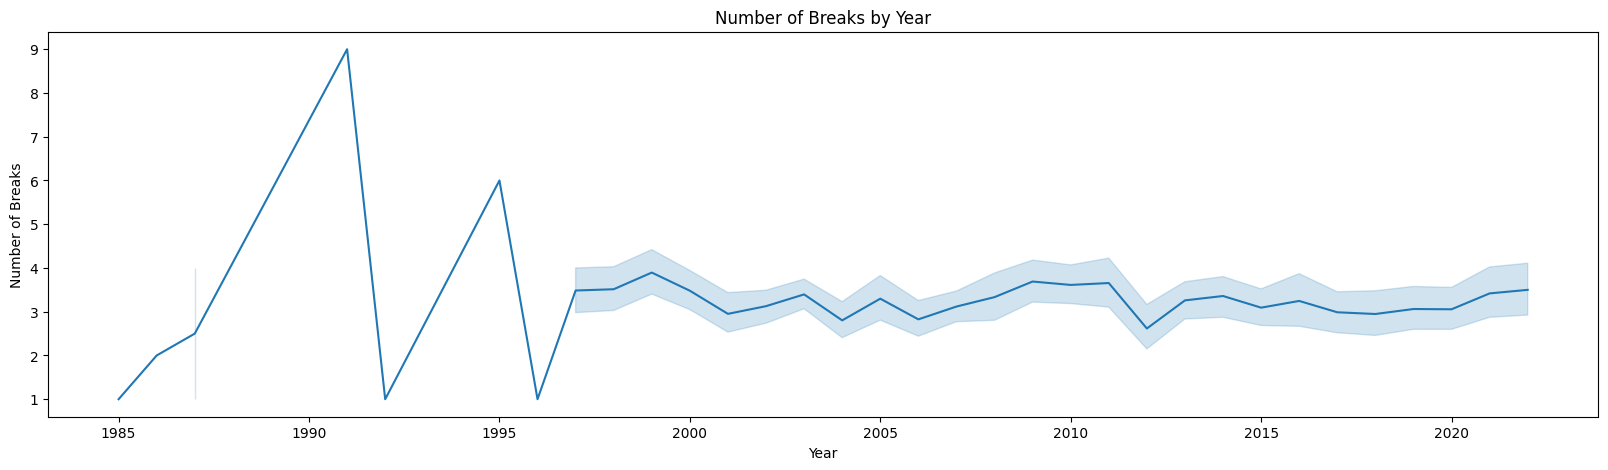

In [17]:
plt.figure(figsize=(20, 5))
sns.lineplot(x="year", y="breaks", data=break_data)
plt.title('Number of Breaks by Year')
plt.xlabel('Year')
plt.ylabel('Number of Breaks')
plt.show()

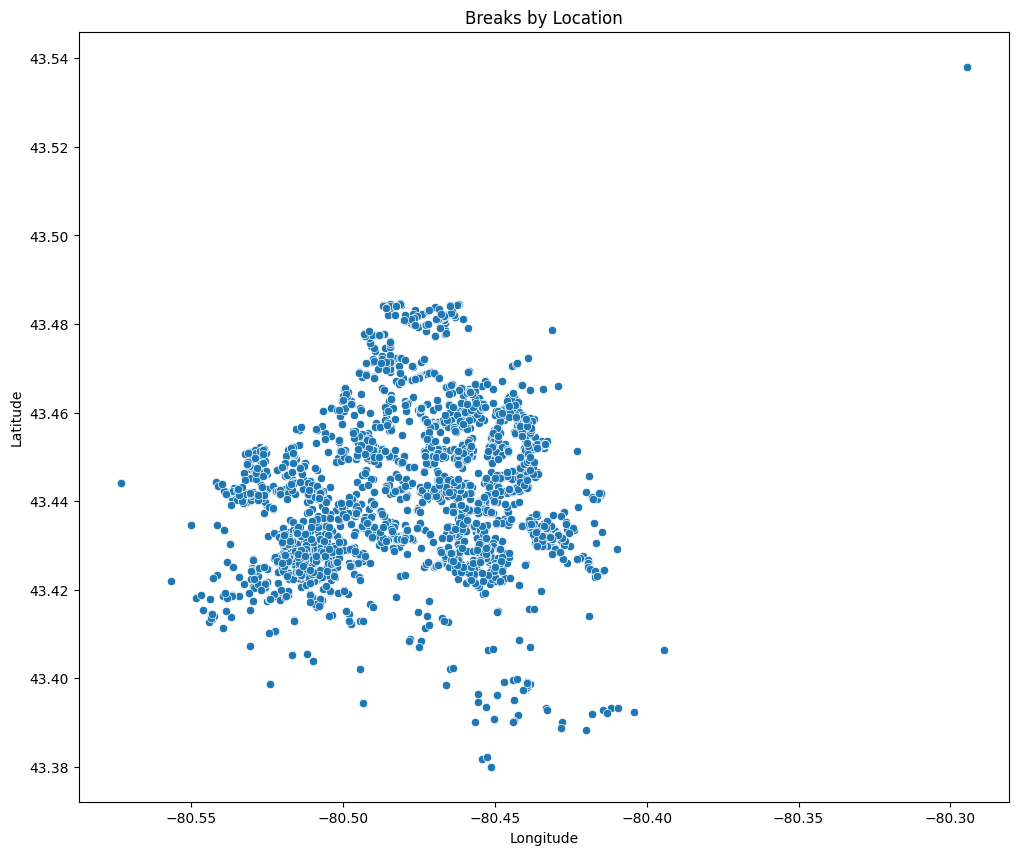

In [18]:
# plot where the breaks occurred
plt.figure(figsize=(12, 10))  # set figure size
sns.scatterplot(x="lon", y="lat", data=break_data)  # plot scatterplot of lon and lat
plt.title('Breaks by Location')  # add title
plt.xlabel('Longitude')  # add x label
plt.ylabel('Latitude')  # add y label
plt.show()  # show plot

In [19]:
import config
import gmaps
import gmaps.datasets
gmaps.configure(api_key=config.gmaps_api_key)

In [20]:
lat = break_data['lat'].values
lon = break_data['lon'].values
break_locations = list(zip(lat, lon))
fig = gmaps.figure()
break_map = gmaps.heatmap_layer(break_locations)
fig.add_layer(break_map)
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [29]:
px.set_mapbox_access_token(config.token)
token = config.token
fig = px.scatter_mapbox(data_frame=break_data, lat='lat', lon='lon',
                        color='year', size='breaks', hover_name='street',
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style='carto-positron', mapbox_accesstoken=token)
fig.show(renderer='notebook_connected')